In [1]:
import numpy as np
from point_history import getmes
import pickle
import datetime
from get_point_map import get
from get_point_history import pget
from netCDF4 import Dataset
import pandas as pd
from ipywidgets import interact
import matplotlib.pyplot as plt

In [2]:
import scipy.io

In [3]:
import folium

In [4]:
import itertools

In [5]:
from pandas.compat import u

In [6]:
%matplotlib notebook

In [7]:
SAVEPATH='tmp/'

In [8]:
path='/mnt/web/brey/hincast/'

In [9]:
SAVEPATH='tmp/'#/mnt/pandora/Users_Critech/Thomas/HYFLUX/'

In [10]:
basename='med'

In [20]:
t1='20150121.00'

In [21]:
t2='20150211.12'

In [22]:
sdate=datetime.datetime.strptime(t1,'%Y%m%d.%H')

In [23]:
edate=datetime.datetime.strptime(t2,'%Y%m%d.%H')

In [24]:
path0=path+'{}/'.format(t1)

In [25]:
with open(path0+basename+'.pkl', 'r') as f:
    ptr=pickle.load(f)

In [49]:
iloc=1870 # CHANGE THIS FOR ANALYSIS OF ANOTHER OBS POINT

In [50]:
t,s,plat,plon,bname,bid = getmes(sdate,edate,iloc) # measured data
dic0={'t_gauge':t, 'sh':[a for [a,b,c] in s], 'tide':[b for [a,b,c] in s], 'ss':[c for [a,b,c] in s]}
data0=pd.DataFrame(dic0)
data0=data0.set_index('t_gauge')


In [51]:
tcw,cw,mlat,mlon,jc,ic=get(t1,t2,path,basename,plat,plon) # map interpolated data
dic1={'t_map':tcw, 's_map':cw}
data1=pd.DataFrame.from_dict(dic1)
data1=data1.set_index('t_map')
data=data0.join(data1, how='outer')

In [52]:
hcw,hw,hlat,hlon=pget(t1,t2,path,basename,ptr[iloc]) # obs point 1 min sampling 
dic2={'t_his':hcw, 's_his':hw}
data2=pd.DataFrame.from_dict(dic2)
data2=data2.set_index('t_his')
data=data.join(data2, how='outer')

In [53]:
#check that the 'returned' iDs are the same as the read ones
np.int(bid) == iloc

True

In [54]:
data.head()

,sh,ss,tide,s_map,s_his
2015-01-21 00:00:00,NaN,NaN,NaN,0.169788,0.169788
2015-01-21 00:01:00,NaN,NaN,NaN,NaN,0.169647
2015-01-21 00:02:00,NaN,NaN,NaN,NaN,0.169773
2015-01-21 00:03:00,NaN,NaN,NaN,NaN,0.170295
2015-01-21 00:04:00,NaN,NaN,NaN,NaN,0.171312


In [55]:
if data['sh'].dropna().sum() is 0:
    print 'no obs, replacing with zeros'
    data[['sh','ss','tide']]=0.0

In [56]:
data.head()

,sh,ss,tide,s_map,s_his
2015-01-21 00:00:00,NaN,NaN,NaN,0.169788,0.169788
2015-01-21 00:01:00,NaN,NaN,NaN,NaN,0.169647
2015-01-21 00:02:00,NaN,NaN,NaN,NaN,0.169773
2015-01-21 00:03:00,NaN,NaN,NaN,NaN,0.170295
2015-01-21 00:04:00,NaN,NaN,NaN,NaN,0.171312


### read grid 

In [57]:
d=Dataset(path0+'trim-'+basename+'.nc')

In [58]:
xg=d['XCOR'][:]
yg=d['YCOR'][:]

In [59]:
xz=d['XZ'][:]
yz=d['YZ'][:]

In [60]:
mapa = folium.Map(location=[plat, plon], zoom_start=12)

In [61]:
folium.Marker([plat,plon], popup=bname).add_to(mapa)

In [62]:
plat,plon, ic, jc

('45.418', '12.427', 269, 253)

In [63]:
folium.CircleMarker([yz[ic,jc],xz[ic,jc]], popup='{},{}/{},{}'.format(mlat,mlon,jc,ic)).add_to(mapa)

In [64]:
folium.CircleMarker([mlat,mlon], popup='{},{}'.format(mlat,mlon),fill_color='blue').add_to(mapa)

In [65]:
mlat,mlon

(45.390982600000001, 12.422544985000002)

In [66]:
folium.CircleMarker([hlat,hlon], popup='{},{}'.format(hlat,hlon),fill_color='green').add_to(mapa)

In [67]:
%%skip
folium.LatLngPopup().add_to(mapa) # click to show lat lon

In [68]:
a=np.arange(-5,5)
b=np.arange(-5,5)
glist=[]
for r in itertools.product(a,b): glist.append((r[0],r[1]))
#glist

In [69]:
for k,l in glist:
    try:
        m1=ic+k
        m2=jc+l
        xgrid=zip(yg[m1,m2-5:m2+5],xg[m1,m2-5:m2+5])
        ygrid=zip(yg[m1-5:m1+5,m2],xg[m1-5:m1+5,m2])
        folium.PolyLine(xgrid,weight=1, color='black').add_to(mapa)
        folium.PolyLine(ygrid,weight=1, color='black').add_to(mapa)
        folium.CircleMarker([yg[m1,m2],xg[m1,m2]], popup='{},{}'.format(m1,m2), radius=50).add_to(mapa)
        folium.CircleMarker([yz[m1,m2],xz[m1,m2]], popup='{},{}'.format(m1,m2), radius=50, fill_color='red').add_to(mapa)
    except Exception as e:
        print e
        pass

In [70]:
mapa

<IPython.core.display.Javascript object>


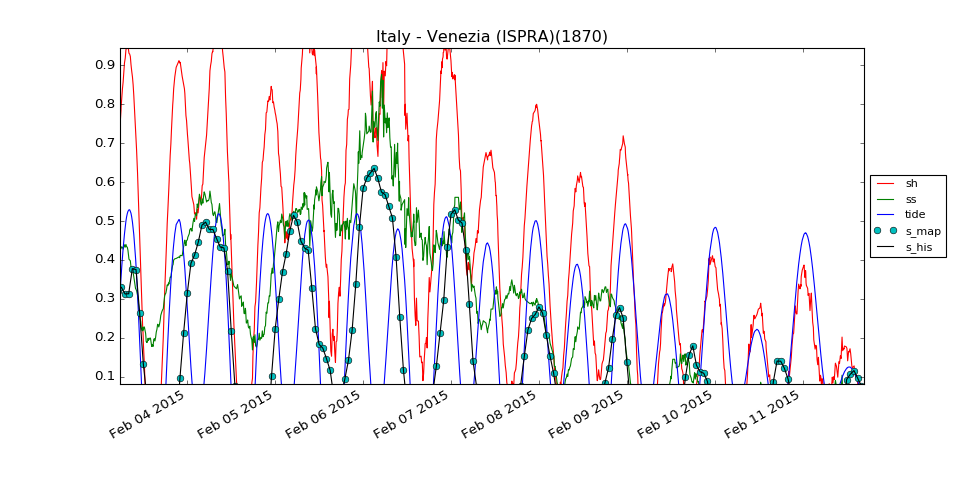

In [71]:
ax=data[['sh','ss','tide']].dropna().apply(pd.to_numeric).plot(figsize=(12,6),style=['r-','g-','b-'])
data[['s_map','s_his']].dropna().apply(pd.to_numeric).plot(ax=ax, style=['co','k-'])
ax.legend(loc='center left', bbox_to_anchor=(1.,.5), prop={'size':10})
ax.set_title(bname+'('+bid+')')

<IPython.core.display.Javascript object>


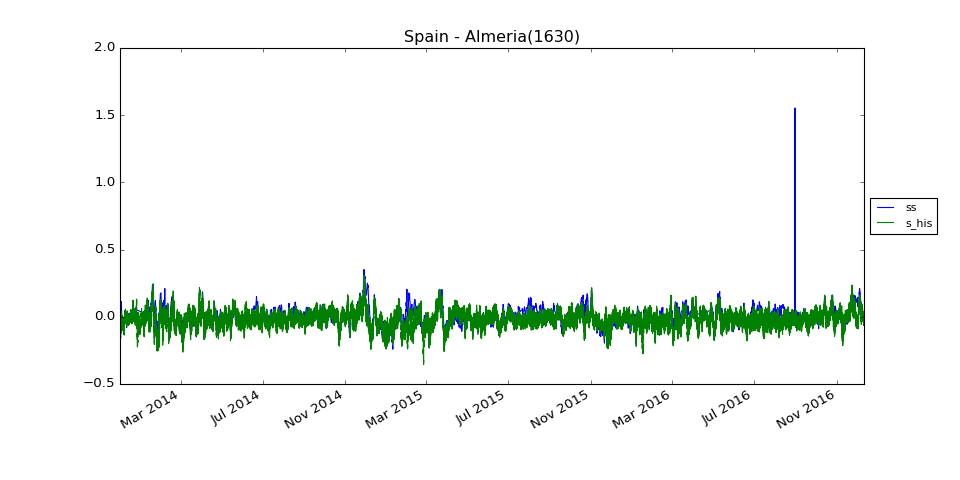

In [40]:
ax1=data['ss'].dropna().apply(pd.to_numeric).plot(figsize=(12,6),style=['b-'])
data['s_his'].dropna().apply(pd.to_numeric).plot(ax=ax1, style=['g-'])
ax1.legend(loc='center left', bbox_to_anchor=(1.,.5), prop={'size':10})
ax1.set_title(bname+'('+bid+')')

## check variance

In [41]:
obs = data['ss'].dropna().apply(pd.to_numeric)

In [42]:
num = data['s_his'].dropna().apply(pd.to_numeric)

computer rolling mean every 60 points

In [43]:
ma = obs.rolling(60).mean()

In [44]:
mstd = obs.rolling(60).std() #standard deviation

<IPython.core.display.Javascript object>


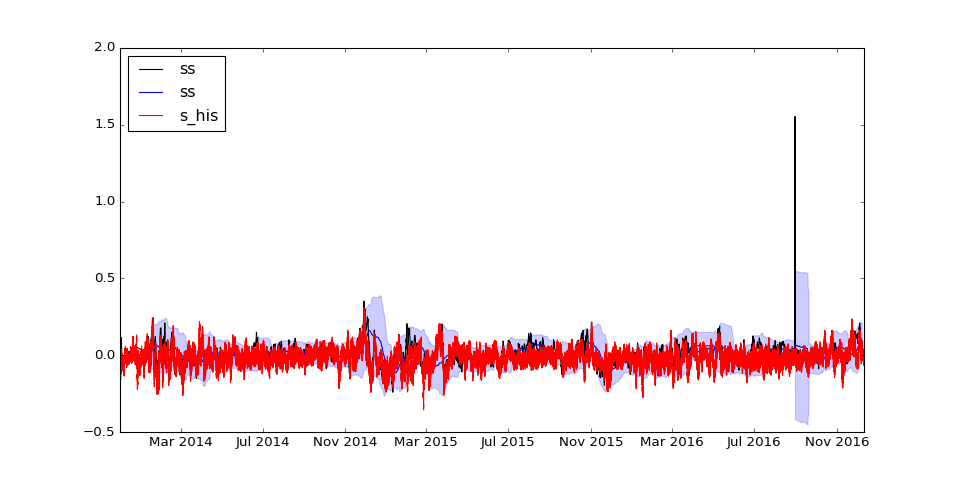

In [57]:
#plot them
plt.figure(figsize=(12,6))
plt.plot(obs.index, obs, 'k')
plt.plot(ma.index, ma, 'b')
plt.plot(num.index, num, 'r')
plt.fill_between(mstd.index, ma-2*mstd, ma+2*mstd, color='b', alpha=0.2)
plt.legend(loc=0)

## Get All forecasting data

In [18]:
dt=(edate-sdate).total_seconds()
ndt=dt/(3600*12)
ndt=np.int(ndt)+1

In [19]:
combined=[] # store time and height
tstamp = [] # for use later

In [20]:
tot=[]

In [21]:
indx=pd.date_range(sdate, edate, freq='12H')

In [22]:
val=[]

In [23]:
for it in range(ndt):
    idate=sdate+datetime.timedelta(hours=12*it)
    dstamp=datetime.datetime.strftime(idate,'%Y%m%d.%H')
    path0=path+'{}/'.format(dstamp)
    filename=path0+'trih-'+basename+'.nc'
    d =  Dataset(filename)
    ha=d.variables['ZWL'][:,ptr[iloc]] # all values
    t=d.variables['time'][:]
    tw=[]
    for it in t:
        tw.append(idate+datetime.timedelta(seconds=np.int(it)))
    ttw=[(item-t[0])/60. for item in t]
    dic={'time':tw, 'numerical storm surge':ha, 'forecast_time':ttw}
    val.append(ha)
    data=pd.DataFrame.from_dict(dic)
    data=data.set_index('time')
    tot.append(data)

In [24]:
tota=pd.concat(tot,keys=indx)

In [25]:
tota.head()

forecast_time  numerical storm surge
           time                                                     
2013-12-01 2013-12-01 00:00:00            0.0               0.005537
           2013-12-01 00:01:00            1.0               0.005778
           2013-12-01 00:02:00            2.0               0.006035
           2013-12-01 00:03:00            3.0               0.006353
           2013-12-01 00:04:00            4.0               0.006755

In [26]:
dat=tota.drop('forecast_time',1)

In [225]:
dat.head()

numerical storm surge
           time                                      
2013-12-01 2013-12-01 00:00:00               0.005537
           2013-12-01 00:01:00               0.005778
           2013-12-01 00:02:00               0.006035
           2013-12-01 00:03:00               0.006353
           2013-12-01 00:04:00               0.006755

## plot all forecasts

In [ ]:
dat.unstack(level=0).plot(figsize=(12,6),legend=False)

In [ ]:
## save the data
dat.to_csv(SAVEPATH+bname+'time_ref.csv', header=None)

## Analysis 

In [355]:
mindx=dat.xs('2013-12-21 00:00:00')

### average of 5 minutes 

In [356]:
mindx.rolling(5,center=True).mean()[::60][:10] # rolling mean ever 5 values, given every 60 indeces 

,numerical storm surge
time,
2013-12-21 00:00:00,NaN
2013-12-21 01:00:00,-0.020928
2013-12-21 02:00:00,-0.041718
2013-12-21 03:00:00,-0.067237
2013-12-21 04:00:00,-0.090309
2013-12-21 05:00:00,-0.120206
2013-12-21 06:00:00,-0.095912
2013-12-21 07:00:00,-0.080744
2013-12-21 08:00:00,-0.096900


In [357]:
#Test the above
ar=[]
for i in range(0,mindx.shape[0],60):
    ar.append(np.mean(mindx[i-2:i+3]))
ar[:10]    

[numerical storm surge   NaN
 dtype: float32, numerical storm surge   -0.020928
 dtype: float32, numerical storm surge   -0.041718
 dtype: float32, numerical storm surge   -0.067237
 dtype: float32, numerical storm surge   -0.090309
 dtype: float32, numerical storm surge   -0.120206
 dtype: float32, numerical storm surge   -0.095912
 dtype: float32, numerical storm surge   -0.080744
 dtype: float32, numerical storm surge   -0.0969
 dtype: float32, numerical storm surge   -0.069816
 dtype: float32]

### maximum of hourly data

In [358]:
mindx.rolling(60,center=True).max()[::60][:10]


,numerical storm surge
time,
2013-12-21 00:00:00,NaN
2013-12-21 01:00:00,-0.020258
2013-12-21 02:00:00,-0.030580
2013-12-21 03:00:00,-0.029951
2013-12-21 04:00:00,-0.073899
2013-12-21 05:00:00,-0.096839
2013-12-21 06:00:00,-0.089474
2013-12-21 07:00:00,-0.080071
2013-12-21 08:00:00,-0.080003


In [359]:
# test
ar=[]
for i in range(0,mindx.shape[0],60):
    ar.append(np.max(mindx[i-30:i+31]))
ar[:10]    

[numerical storm surge   NaN
 dtype: float64, numerical storm surge   -0.020258
 dtype: float32, numerical storm surge   -0.029951
 dtype: float32, numerical storm surge   -0.029951
 dtype: float32, numerical storm surge   -0.073899
 dtype: float32, numerical storm surge   -0.09611
 dtype: float32, numerical storm surge   -0.089474
 dtype: float32, numerical storm surge   -0.080071
 dtype: float32, numerical storm surge   -0.080003
 dtype: float32, numerical storm surge   -0.061156
 dtype: float32]

## compute corellation between measured and computed

In [51]:
num.head()

2013-12-01 00:00:00    0.005537
2013-12-01 00:01:00    0.005778
2013-12-01 00:02:00    0.006035
2013-12-01 00:03:00    0.006353
2013-12-01 00:04:00    0.006755
Name: s_his, dtype: float64

In [52]:
obs.head()

2013-12-01 04:38:00    0.069
2013-12-02 06:13:00    0.042
2013-12-02 06:59:00    0.034
2013-12-02 22:36:00    0.114
2013-12-03 09:38:00    0.037
Name: ss, dtype: float64

In [53]:
rnum=num.reindex(obs.index,method='pad')

In [54]:
rnum.corr(obs) #total correlation

0.55531211287045568

In [55]:
rnum.rolling(window=10, center=True).corr(obs).mean()

0.50987397617691399

<IPython.core.display.Javascript object>


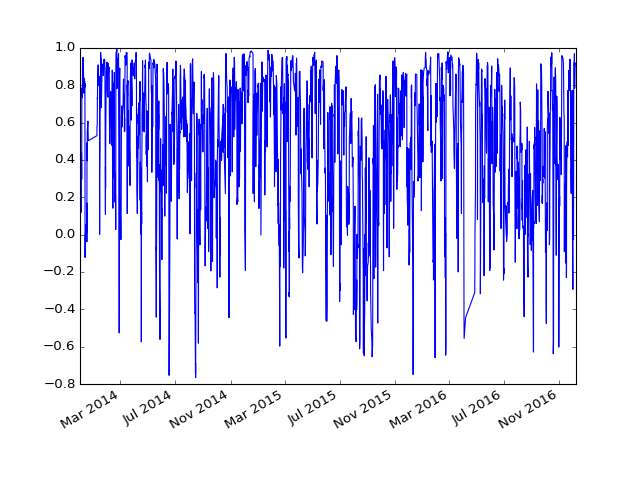

In [58]:
rnum.rolling(window=10, center=True).corr(obs).plot()

## replace index

In [27]:
tota.head()

forecast_time  numerical storm surge
           time                                                     
2013-12-01 2013-12-01 00:00:00            0.0               0.005537
           2013-12-01 00:01:00            1.0               0.005778
           2013-12-01 00:02:00            2.0               0.006035
           2013-12-01 00:03:00            3.0               0.006353
           2013-12-01 00:04:00            4.0               0.006755

In [28]:
#tota.index=tota.index.droplevel(1)

In [29]:
tota.drop('forecast_time',1, inplace=True)

In [30]:
#tota.reset_index(level=0, inplace=True)

In [31]:
#tota.set_index(['index','forecast_time'], inplace=True)

In [32]:
tota.head()

numerical storm surge
           time                                      
2013-12-01 2013-12-01 00:00:00               0.005537
           2013-12-01 00:01:00               0.005778
           2013-12-01 00:02:00               0.006035
           2013-12-01 00:03:00               0.006353
           2013-12-01 00:04:00               0.006755

In [33]:
tota.index.tolist()[:10]

[(Timestamp('2013-12-01 00:00:00'), Timestamp('2013-12-01 00:00:00')),
 (Timestamp('2013-12-01 00:00:00'), Timestamp('2013-12-01 00:01:00')),
 (Timestamp('2013-12-01 00:00:00'), Timestamp('2013-12-01 00:02:00')),
 (Timestamp('2013-12-01 00:00:00'), Timestamp('2013-12-01 00:03:00')),
 (Timestamp('2013-12-01 00:00:00'), Timestamp('2013-12-01 00:04:00')),
 (Timestamp('2013-12-01 00:00:00'), Timestamp('2013-12-01 00:05:00')),
 (Timestamp('2013-12-01 00:00:00'), Timestamp('2013-12-01 00:06:00')),
 (Timestamp('2013-12-01 00:00:00'), Timestamp('2013-12-01 00:07:00')),
 (Timestamp('2013-12-01 00:00:00'), Timestamp('2013-12-01 00:08:00')),
 (Timestamp('2013-12-01 00:00:00'), Timestamp('2013-12-01 00:09:00'))]

In [34]:
ht=np.array([np.arange(4321) for i in range(tota.index.levels[0].shape[0])]).ravel()

In [35]:
ht.shape

(7095082,)

In [36]:
len(tota.index.tolist())

7095082

In [37]:
index0=[(a, c) for (a,b),c in zip(tota.index.tolist(),ht)]

In [38]:
tota.index=pd.MultiIndex.from_tuples(index0,names=tota.index.names)

In [39]:
tota.head()

numerical storm surge
           time                       
2013-12-01 0                  0.005537
           1                  0.005778
           2                  0.006035
           3                  0.006353
           4                  0.006755

In [40]:
tota.unstack(level=0).head()

numerical storm surge                                          \
       2013-12-01 00:00:00 2013-12-01 12:00:00 2013-12-02 00:00:00   
time                                                                 
0                 0.005537           -0.043900           -0.138706   
1                 0.005778           -0.043640           -0.137605   
2                 0.006035           -0.043522           -0.136266   
3                 0.006353           -0.043555           -0.134740   
4                 0.006755           -0.043754           -0.133100   

                                                                  \
     2013-12-02 12:00:00 2013-12-03 00:00:00 2013-12-03 12:00:00   
time                                                               
0              -0.030800           -0.042397           -0.076252   
1              -0.031064           -0.042507           -0.078262   
2              -0.031425           -0.042363           -0.080190   
3              -0.031856           -0.041957           -0.081935   
4              -0.032323           -0.041293           -0.083412   

                                                                  \
     2013-12-04 00:00:00 2013-12-04 12:00:00 2013-12-05 00:00:00   
time                                                               
0              -0.052062           -0.084320           -0.060959   
1              -0.053670           -0.085714           -0.061719   
2              -0.055411           -0.086946           -0.062580   
3              -0.057179           -0.088011           -0.063537   
4              -0.058899           -0.088907           -0.064574   

                                 ...                              \
     2013-12-05 12:00:00         ...         2016-02-25 00:00:00   
time                             ...                               
0              -0.063311         ...                   -0.040074   
1              -0.063414         ...                   -0.037908   
2              -0.063785         ...                   -0.035779   
3              -0.064413         ...                   -0.034152   
4              -0.065290         ...                   -0.033372   

                                                                  \
     2016-02-25 12:00:00 2016-02-26 00:00:00 2016-02-26 12:00:00   
time                                                               
0              -0.028216           -0.059162           -0.067401   
1              -0.026527           -0.060904           -0.068685   
2              -0.024167           -0.062185           -0.069930   
3              -0.021478           -0.062849           -0.070757   
4              -0.018910           -0.062968           -0.070920   

                                                                  \
     2016-02-27 00:00:00 2016-02-27 12:00:00 2016-02-28 00:00:00   
time                                                               
0               0.045699            0.068263            0.128071   
1               0.044757            0.070782            0.127292   
2               0.043291            0.072857            0.126263   
3               0.041577            0.074527            0.124878   
4               0.039935            0.075983            0.123143   

                                                                  
     2016-02-28 12:00:00 2016-02-29 00:00:00 2016-02-29 12:00:00  
time                                                              
0               0.047023           -0.052654           -0.042287  
1               0.047575           -0.053261           -0.041034  
2               0.048533           -0.053368           -0.039823  
3               0.049734           -0.053123           -0.038746  
4               0.051019           -0.052722           -0.037984  

[5 rows x 1642 columns]

### rolling average for all

In [41]:
s=tota.unstack(level=0)

In [42]:
s.head()

numerical storm surge                                          \
       2013-12-01 00:00:00 2013-12-01 12:00:00 2013-12-02 00:00:00   
time                                                                 
0                 0.005537           -0.043900           -0.138706   
1                 0.005778           -0.043640           -0.137605   
2                 0.006035           -0.043522           -0.136266   
3                 0.006353           -0.043555           -0.134740   
4                 0.006755           -0.043754           -0.133100   

                                                                  \
     2013-12-02 12:00:00 2013-12-03 00:00:00 2013-12-03 12:00:00   
time                                                               
0              -0.030800           -0.042397           -0.076252   
1              -0.031064           -0.042507           -0.078262   
2              -0.031425           -0.042363           -0.080190   
3              -0.031856           -0.041957           -0.081935   
4              -0.032323           -0.041293           -0.083412   

                                                                  \
     2013-12-04 00:00:00 2013-12-04 12:00:00 2013-12-05 00:00:00   
time                                                               
0              -0.052062           -0.084320           -0.060959   
1              -0.053670           -0.085714           -0.061719   
2              -0.055411           -0.086946           -0.062580   
3              -0.057179           -0.088011           -0.063537   
4              -0.058899           -0.088907           -0.064574   

                                 ...                              \
     2013-12-05 12:00:00         ...         2016-02-25 00:00:00   
time                             ...                               
0              -0.063311         ...                   -0.040074   
1              -0.063414         ...                   -0.037908   
2              -0.063785         ...                   -0.035779   
3              -0.064413         ...                   -0.034152   
4              -0.065290         ...                   -0.033372   

                                                                  \
     2016-02-25 12:00:00 2016-02-26 00:00:00 2016-02-26 12:00:00   
time                                                               
0              -0.028216           -0.059162           -0.067401   
1              -0.026527           -0.060904           -0.068685   
2              -0.024167           -0.062185           -0.069930   
3              -0.021478           -0.062849           -0.070757   
4              -0.018910           -0.062968           -0.070920   

                                                                  \
     2016-02-27 00:00:00 2016-02-27 12:00:00 2016-02-28 00:00:00   
time                                                               
0               0.045699            0.068263            0.128071   
1               0.044757            0.070782            0.127292   
2               0.043291            0.072857            0.126263   
3               0.041577            0.074527            0.124878   
4               0.039935            0.075983            0.123143   

                                                                  
     2016-02-28 12:00:00 2016-02-29 00:00:00 2016-02-29 12:00:00  
time                                                              
0               0.047023           -0.052654           -0.042287  
1               0.047575           -0.053261           -0.041034  
2               0.048533           -0.053368           -0.039823  
3               0.049734           -0.053123           -0.038746  
4               0.051019           -0.052722           -0.037984  

[5 rows x 1642 columns]

In [373]:
s.rolling(60,center=True).max()[::60] # max within 1 hour centered on the hour

numerical storm surge                                          \
       2013-12-01 00:00:00 2013-12-01 12:00:00 2013-12-02 00:00:00   
time                                                                 
0                      NaN                 NaN                 NaN   
60               -0.081157            0.119435            0.078607   
120              -0.067438            0.133171            0.096184   
180              -0.050100            0.121900            0.119054   
240              -0.066086            0.099442            0.141245   
300              -0.026576            0.094809            0.148900   
360              -0.009115            0.065730            0.137231   
420               0.008983            0.041875            0.145802   
480               0.033048            0.027662            0.148121   
540               0.076296            0.035536            0.145294   
600               0.078510            0.021661            0.132598   
660               0.091865            0.026736            0.115289   
720               0.101002            0.058952            0.107076   
780               0.113162            0.081842            0.074860   
840               0.123368            0.090630            0.046774   
900               0.120825            0.108396            0.025141   
960               0.107501            0.134315           -0.020881   
1020              0.101842            0.143716           -0.055552   
1080              0.067301            0.135571           -0.115835   
1140              0.038945            0.144036           -0.155976   
1200              0.018463            0.144134           -0.173472   
1260             -0.002802            0.140966           -0.158901   
1320             -0.002039            0.121459           -0.127400   
1380              0.000618            0.104245           -0.109283   
1440              0.020534            0.111483           -0.074726   
1500              0.045734            0.081420           -0.043406   
1560              0.056563            0.059942           -0.035889   
1620              0.070622            0.030104           -0.030945   
1680              0.085326           -0.012378           -0.029928   
1740              0.099902           -0.062453           -0.005410   
...                    ...                 ...                 ...   
2580             -0.150068            0.045440           -0.152443   
2640             -0.158299            0.052547           -0.153291   
2700             -0.166737            0.057597           -0.132529   
2760             -0.157110            0.051181           -0.103380   
2820             -0.136752            0.036354           -0.085317   
2880             -0.115517            0.024639           -0.069834   
2940             -0.083203           -0.015477           -0.033400   
3000             -0.067492           -0.027391           -0.022716   
3060             -0.037941           -0.046502           -0.009813   
3120             -0.024546           -0.084280            0.010242   
3180             -0.007421           -0.113392            0.019325   
3240              0.028191           -0.135251            0.028259   
3300              0.045134           -0.151381            0.031863   
3360              0.057171           -0.159584            0.017944   
3420              0.062706           -0.143160            0.006164   
3480              0.062142           -0.113056            0.001335   
3540              0.049630           -0.098856           -0.036539   
3600              0.032893           -0.071123           -0.045799   
3660              0.006300           -0.025706           -0.058112   
3720             -0.018423           -0.018330           -0.085707   
3780             -0.037143           -0.000208           -0.104000   
3840             -0.069960            0.017989           -0.125418   
3900             -0.112943            0.020033           -0.124999   
3960           

### test the above values

In [374]:
testd=s.iloc[:,s.columns.get_level_values(1)=='2013-12-23 00:00:00']

In [375]:
testd.rolling(60,center=True).max()[::60][:10]

,numerical storm surge
,2013-12-23
time,
0,NaN
60,-0.067535
120,-0.070219
180,-0.073667
240,-0.066043
300,-0.046314
360,-0.041350
420,-0.036934


In [376]:
testd[90:150].max()

numerical storm surge  2013-12-23   -0.070219
dtype: float32

In [377]:
ar=[]
for i in range(0,testd.shape[0],60):
    ar.append(np.max(testd[i-30:i+30]))
ar[:10]   

[numerical storm surge  2013-12-23   NaN
 dtype: float64, numerical storm surge  2013-12-23   -0.067535
 dtype: float32, numerical storm surge  2013-12-23   -0.070219
 dtype: float32, numerical storm surge  2013-12-23   -0.073667
 dtype: float32, numerical storm surge  2013-12-23   -0.066043
 dtype: float32, numerical storm surge  2013-12-23   -0.046314
 dtype: float32, numerical storm surge  2013-12-23   -0.04135
 dtype: float32, numerical storm surge  2013-12-23   -0.036934
 dtype: float32, numerical storm surge  2013-12-23   -0.024604
 dtype: float32, numerical storm surge  2013-12-23   -0.001141
 dtype: float32]

In [ ]:
## save the data
s.to_csv(SAVEPATH+bname+'forecast.csv')

#### output for verif

In [114]:
av5=s.rolling(5,center=True, min_periods=3).mean()[::60]#[:25] # mean within 5 min for every hour centered

In [115]:
av5

numerical storm surge                                          \
       2013-12-01 00:00:00 2013-12-01 12:00:00 2013-12-02 00:00:00   
time                                                                 
0                 0.005783           -0.043688           -0.137526   
60                0.037880           -0.052716           -0.101242   
120               0.038775           -0.030917           -0.067542   
180               0.007631           -0.055568           -0.069785   
240              -0.007422           -0.083612           -0.093101   
300              -0.022547           -0.102237           -0.108110   
360              -0.005129           -0.082570           -0.101247   
420               0.021844           -0.083483           -0.062346   
480               0.021742           -0.091683           -0.033676   
540              -0.001055           -0.126607           -0.012547   
600              -0.039362           -0.138239           -0.035235   
660              -0.067753           -0.147076           -0.046070   
720              -0.044026           -0.138451           -0.030929   
780              -0.050242           -0.100337            0.013621   
840              -0.034589           -0.072211            0.024140   
900              -0.060488           -0.074161            0.033014   
960              -0.090637           -0.097774            0.004118   
1020             -0.113685           -0.108347            0.007060   
1080             -0.092192           -0.101507           -0.009957   
1140             -0.093221           -0.064059            0.023935   
1200             -0.097688           -0.032535            0.014289   
1260             -0.126811           -0.017026            0.010114   
1320             -0.138250           -0.039938           -0.005820   
1380             -0.148820           -0.046638           -0.020869   
1440             -0.147522           -0.027289           -0.034442   
1500             -0.116766            0.016817           -0.027894   
1560             -0.082066            0.030076            0.005797   
1620             -0.076620            0.035110            0.017967   
1680             -0.098109            0.005179           -0.012955   
1740             -0.108670            0.001884           -0.056958   
...                    ...                 ...                 ...   
2580              0.011327           -0.065632           -0.044216   
2640              0.014070           -0.054274           -0.016299   
2700              0.008588           -0.032926           -0.009266   
2760             -0.006840           -0.044741           -0.017402   
2820             -0.021112           -0.067900           -0.028650   
2880             -0.031861           -0.065330           -0.030122   
2940             -0.025209           -0.049480           -0.038100   
3000             -0.004281           -0.028105           -0.028259   
3060             -0.001017           -0.031157           -0.013985   
3120             -0.029024           -0.042577           -0.016201   
3180             -0.067286           -0.054165           -0.033698   
3240             -0.068023           -0.076293           -0.034328   
3300             -0.066617           -0.048291           -0.031758   
3360             -0.056787           -0.020804           -0.026554   
3420             -0.036848           -0.013712           -0.019233   
3480             -0.049736           -0.022086           -0.046894   
3540             -0.073891           -0.034213           -0.063179   
3600             -0.072474           -0.040825           -0.081756   
3660             -0.062419           -0.049577           -0.070402   
3720             -0.038394           -0.036923           -0.035497   
3780             -0.033230           -0.017421           -0.024812   
3840             -0.040420           -0.020655           -0.026587   
3900             -0.054640           -0.043290           -0.047708   
3960           

In [116]:
av5.index=av5.index/60

In [117]:
av5

numerical storm surge                                          \
       2013-12-01 00:00:00 2013-12-01 12:00:00 2013-12-02 00:00:00   
time                                                                 
0                 0.005783           -0.043688           -0.137526   
1                 0.037880           -0.052716           -0.101242   
2                 0.038775           -0.030917           -0.067542   
3                 0.007631           -0.055568           -0.069785   
4                -0.007422           -0.083612           -0.093101   
5                -0.022547           -0.102237           -0.108110   
6                -0.005129           -0.082570           -0.101247   
7                 0.021844           -0.083483           -0.062346   
8                 0.021742           -0.091683           -0.033676   
9                -0.001055           -0.126607           -0.012547   
10               -0.039362           -0.138239           -0.035235   
11               -0.067753           -0.147076           -0.046070   
12               -0.044026           -0.138451           -0.030929   
13               -0.050242           -0.100337            0.013621   
14               -0.034589           -0.072211            0.024140   
15               -0.060488           -0.074161            0.033014   
16               -0.090637           -0.097774            0.004118   
17               -0.113685           -0.108347            0.007060   
18               -0.092192           -0.101507           -0.009957   
19               -0.093221           -0.064059            0.023935   
20               -0.097688           -0.032535            0.014289   
21               -0.126811           -0.017026            0.010114   
22               -0.138250           -0.039938           -0.005820   
23               -0.148820           -0.046638           -0.020869   
24               -0.147522           -0.027289           -0.034442   
25               -0.116766            0.016817           -0.027894   
26               -0.082066            0.030076            0.005797   
27               -0.076620            0.035110            0.017967   
28               -0.098109            0.005179           -0.012955   
29               -0.108670            0.001884           -0.056958   
...                    ...                 ...                 ...   
43                0.011327           -0.065632           -0.044216   
44                0.014070           -0.054274           -0.016299   
45                0.008588           -0.032926           -0.009266   
46               -0.006840           -0.044741           -0.017402   
47               -0.021112           -0.067900           -0.028650   
48               -0.031861           -0.065330           -0.030122   
49               -0.025209           -0.049480           -0.038100   
50               -0.004281           -0.028105           -0.028259   
51               -0.001017           -0.031157           -0.013985   
52               -0.029024           -0.042577           -0.016201   
53               -0.067286           -0.054165           -0.033698   
54               -0.068023           -0.076293           -0.034328   
55               -0.066617           -0.048291           -0.031758   
56               -0.056787           -0.020804           -0.026554   
57               -0.036848           -0.013712           -0.019233   
58               -0.049736           -0.022086           -0.046894   
59               -0.073891           -0.034213           -0.063179   
60               -0.072474           -0.040825           -0.081756   
61               -0.062419           -0.049577           -0.070402   
62               -0.038394           -0.036923           -0.035497   
63               -0.033230           -0.017421           -0.024812   
64               -0.040420           -0.020655           -0.026587   
65               -0.054640           -0.043290           -0.047708   
66             

In [118]:
sav5=av5.unstack()

In [119]:
sav5.index=sav5.index.droplevel(level=0)

In [223]:
sav5.head()

            time
2013-12-01  0       0.005783
            1       0.037880
            2       0.038775
            3       0.007631
            4      -0.007422
dtype: float64

In [224]:
sav5=sav5.round(3)

#### read cleaned obs

In [393]:
#obs=pd.read_csv('/mnt/pandora/Users_Critech/brey/Obs_Ancona_hourly_5min_aver.txt',delimiter='\t', date_parser=True, header=None, names=['time','s'])

In [47]:
mat=scipy.io.loadmat('/mnt/pandora/Users_Critech/Brey/Almei.mat')

In [48]:
obs=pd.DataFrame({'time':mat['times'].flatten(),'s':mat['ss_Almei'].flatten(), 'offset':mat['offset'].flatten()})

In [49]:
obs.head()

,offset,s,time
0,0,0.100667,201312010000
1,1,0.057200,201312010100
2,2,0.058800,201312010200
3,3,0.061600,201312010300
4,4,0.057600,201312010400


In [50]:
#take out the duplicate 24h value
obs=obs[obs.offset != 24]

In [51]:
obs[:26]

,offset,s,time
0,0,0.100667,201312010000
1,1,0.057200,201312010100
2,2,0.058800,201312010200
3,3,0.061600,201312010300
4,4,0.057600,201312010400
5,5,0.086400,201312010500
6,6,0.048000,201312010600
7,7,0.026000,201312010700
8,8,0.035500,201312010800
9,9,0.006400,201312010900


## Create forecast matrix from observation

In [52]:
obs=obs.set_index(['time','offset'])

In [53]:
obs.head()

,,s
time,offset,
201312010000,0,0.100667
201312010100,1,0.057200
201312010200,2,0.058800
201312010300,3,0.061600
201312010400,4,0.057600


In [54]:
obs[-10:]

,,s
time,offset,
201603311400,14,0.0964
201603311500,15,NaN
201603311600,16,0.0820
201603311700,17,0.0726
201603311800,18,0.0684
201603311900,19,0.0848
201603312000,20,0.0602
201603312100,21,0.0592
201603312200,22,0.0365


In [55]:
obse=datetime.datetime.strptime(obs.index.levels[0][-1],'%Y%m%d%H%M')

In [56]:
indx=pd.date_range(sdate, obse, freq='12H')

In [175]:
obsd=[]
for d in indx[:-6]:
    sobs=obs.loc[d.to_pydatetime().strftime('%Y%m%d%H%M'):(d+datetime.timedelta(hours=72)).to_pydatetime().strftime('%Y%m%d%H%M')]['s']
    dic={'time':d, 'obs':sobs, 'offset':np.arange(73)}
    do=pd.DataFrame.from_dict(dic)
    do=do.set_index('time')
    obsd.append(do)

In [212]:
obsf=pd.concat(obsd,keys=indx)

In [213]:
obsf.head()

obs  offset
           time                        
2013-12-01 2013-12-01  0.100667       0
           2013-12-01  0.057200       1
           2013-12-01  0.058800       2
           2013-12-01  0.061600       3
           2013-12-01  0.057600       4

In [214]:
obsf.obs=obsf.obs.apply(pd.to_numeric).round(3)

In [215]:
obsf=obsf.reset_index().drop(['time'], axis=1).set_index(['level_0','offset'])

In [216]:
obsf.index.names=['','time']

In [217]:
obsf.head()

obs
           time       
2013-12-01 0     0.101
           1     0.057
           2     0.059
           3     0.062
           4     0.058

In [218]:
obsf['obs']=obsf['obs'].fillna('NaN')

### join the 2 dataframes

In [225]:
ver=pd.concat([obsf,sav5],axis=1)

In [226]:
output=ver.loc['2013-12-01 00:00:00':'2016-02-29 12:00:00']

In [227]:
output.head()

obs      0
2013-12-01 0  0.101  0.006
           1  0.057  0.038
           2  0.059  0.039
           3  0.062  0.008
           4  0.058 -0.007

#### output

In [228]:
with open('tmp/Almeira.csv', 'w') as f:
    f.write('# variable: s\n')
    f.write('# units: $m$\n')
    f.write('date offset obs fcst\n')


In [229]:
with open('tmp/Almeira.csv', 'a') as f:
        output.to_csv(f, date_format='%Y%m%d%H', sep='\t', header=None)

In [387]:
check=pd.read_csv('tmp/Almeira.csv',skiprows=3, delimiter='\t',header=None,names=['t','offset','obs','fcst'])

<IPython.core.display.Javascript object>


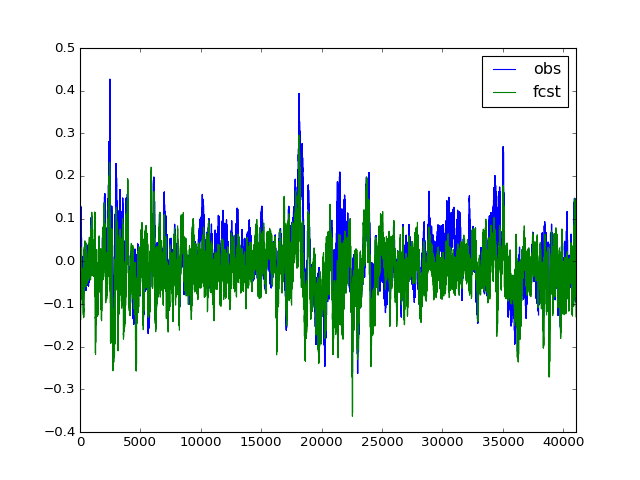

In [390]:
check[['obs','fcst']].plot()